# <center>Milestone 2</center> 

> This notebook contains analyses and data processing for our project, aiming to investigate which event of the last century had the biggest impact on society.

## Table of Contents
* [1. Data Loading and Preprocessing](#1-data-loading-and-preprocessing)
    * [1.1 Data Loading](#11-data-loading)
    * [1.2 Initial Data Preprocessing](#12-initial-data-preprocessing)
    * [1.3 Enrichment of the Movie Dataset](#13-enrichment-of-the-Movie-Dataset)
* [2. General Statistics about the Movie Dataset](#2-general-statistics-about-the-movie-dataset)
    * [2.1 Total Number of Movies](#21-total-number-of-movies)
    * [2.2 Number of Years and Movies per Year](#22-number-of-years-and-movies-per-year)
    * [2.3 NaN Value Analysis](#23-nan-value-analysis)
    * [2.4 Number of Languages](#24-number-of-languages)
    * [2.5 Number of Countries and World Regions](#25-number-of-countries-and-world-regions)
    * [2.6 Number of Genres and Genre Categories](#26-number-of-genres-and-genre-categories)

* [3. Movies Association to Historical Events and Movements](#3-movies-association-to-historical-events-and-movements)
    * [3.1 Creation of Dictionaries](#31-creation-of-dictionaries)
        * [3.1.1 Evaluation using a Test Set](#311-evaluation-using-a-test-set)
            * [3.1.1.1 Test Set and Classification](#3111-test-set-and-classification)
            * [3.1.1.2 Threshold Evaluation](#3112-threshold-evaluation)
            * [3.1.1.3 Performance Statistics of the Classification](#3113-performance-statistics-of-the-classification)
    * [3.2 Match Movie to Event](#32-match-movie-to-event)
    * [3.3 Quality Check of Dictionaries](#33-quality-check-of-dictionaries)
        * [3.3.1 Correlation Matrix](#331-correlation-matrix)
        * [3.3.2 Movies Shared Between Two Events](#332-movies-shared-between-two-events)

* [4. Diving into the Analysis of Events](#4-diving-into-the-analysis-of-events)
    * [4.1 Number of Movies per Event Over the Years](#41-number-of-movies-per-event-over-the-years)
    * [4.2 Number of Countries producing a Movie Matched to an Event](#42-number-of-countries-producing-a-movie-matched-to-an-event)
    * [4.3 Analysis Box Office Revenue](#43-analysis-box-office-revenue)
    * [4.4 Analysis of Ratings](#44-analysis-of-ratings)
    * [4.5 Analysis of Number of Rating Votes](#45-analysis-of-number-of-rating-votes)
    * [4.6 Analysis of Popularity](#46-analysis-of-popularity)
    * [4.7 Sentiment Analysis using Reviews](#47-sentiment-analysis-using-reviews)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import re
import matplotlib.cm as cm
from dateutil.relativedelta import relativedelta
from scipy.stats import f_oneway
from scipy import stats
from sklearn.metrics import confusion_matrix
from collections import Counter
import ast

# Additional functions

from helpers import*

## 1. Data Loading and Preprocessing

### 1.1 Data Loading

> We start with loading the CMU Movies Summary Corpus datasets, obtained from [this source](http://www.cs.cmu.edu/~ark/personas/), along with additional datasets necessary to complement our collection, for [reviews](https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp?select=reviews.csv) and for [ratings and revenues](https://www.kaggle.com/datasets/ebiswas/imdb-review-dataset).



In [2]:
# Paths

DATA_PATH = "data/"


# Specific paths for CMU Movies Summary Corpus datasets

MOVIES_FOLDER = DATA_PATH + "MovieSummaries/"
MOVIES_DATASET = MOVIES_FOLDER + "movie.metadata.tsv"
CHARACTERS_DATASET = MOVIES_FOLDER + "character.metadata.tsv"
CHARACTERS_NAMES_DATASET = MOVIES_FOLDER + "name.clusters.txt"
CHARACTERS_TYPES_DATASET = MOVIES_FOLDER + "tvtropes.clusters.txt"
PLOTS_DATASET = MOVIES_FOLDER + "plot_summaries.txt"


# Specific paths for additional datasets to complement the CMU Movies Summary Corpus datasets

ADDITIONAL_FOLDER = DATA_PATH + "AdditionalDatasets/"
IMDB_DATASET = ADDITIONAL_FOLDER + "imdb_movies.csv"
REVIEWS_DATASET = ADDITIONAL_FOLDER + "movies_events_reviews.csv"


# Import the positive and negative words' list

POSITIVE_URL = "https://ptrckprry.com/course/ssd/data/positive-words.txt"
NEGATIVE_URL = "https://ptrckprry.com/course/ssd/data/negative-words.txt"

In [3]:
# Loading of the CMU Movies Summary Corpus datasets

movies = pd.read_csv(MOVIES_DATASET, sep = '\t', names = ['id_wiki', 'id_freebase', 'name', 'date', 'box_office', 'runtime', 'lang', 'country', 'genre'])
characters = pd.read_csv(CHARACTERS_DATASET, sep = '\t', names = ['id_wiki_movie', 'id_freebase_movie', 'movie_release_date', 'character_name', 'actor_birth_date', 'actor_gender', 'actor_height', 'actor_ethnicity_freebase_id', 'actor_name', 'actor_age_movie_release', 'character_actor_freebase_map_id', 'character_id_freebase', 'actor_id_freebase'])
characters_names = pd.read_csv(CHARACTERS_NAMES_DATASET, sep = '\t', names = ['character_name', 'character_actor_freebase_map_id'])
characters_types = pd.read_csv(CHARACTERS_TYPES_DATASET, sep = '\t', names = ['character_type', 'character_actor_freebase_map_id'])
plot_summaries = pd.read_csv(PLOTS_DATASET, sep = '\t', names = ['id_wiki_movie', 'summary'])


# Loading of additional Review dataset and related word dataframes

movies_events_reviews = pd.read_csv(REVIEWS_DATASET)
positive_words_df = pd.read_csv(POSITIVE_URL, header = 32, names = ['words'], sep = ' ', encoding = 'latin1')
negative_words_df = pd.read_csv(NEGATIVE_URL, header = 32, names = ['words'], sep = ' ', encoding = 'latin1')

> As we need plot summaries for our movie analysis strategy, we merge the plot summaries with the movies dataset now. 
>Since we are executing an inner merge, we simultaneously eliminate any movies that might lack subplots.

In [4]:
movies_df = movies.copy() 
movie_plots = plot_summaries.copy()


# Merging movie and plot_summaries datasets

movies_and_plots = pd.merge(movies_df, movie_plots, how = 'inner', left_on = 'id_wiki', right_on = 'id_wiki_movie').copy()


print("The shape of the movie dataframe before:", movies_df.shape, "; and the shape of the merged dataframe containing movie plots:", movies_and_plots.shape)

The shape of the movie dataframe before: (81741, 9) ; and the shape of the merged dataframe containing movie plots: (42204, 11)


### 1.2 Initial Data Preprocessing

> In order to explore the dataset, some of the data in the movies dataset has to be preprocessed, because it is not in a format we can use. This is the case for the movie release date, the movie genres, the countries of production and the movie languages.
>
>We convert the movie release date to datetime format (we decided to only keep the years for our analysis).
>
>In order to make data handling easier we convert the dictionaries to a list, keeping only the names (not the id) for the columns 'genre', 'country' and 'language'. 

In [5]:
# THIS CELL SHOULD BE RUN ONLY ONCE

movies_and_plots['date'] = pd.to_datetime(movies_and_plots['date'], errors = 'coerce', format = 'mixed').dt.year

movies_and_plots['genre'] = movies_and_plots['genre'].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies_and_plots['country'] = movies_and_plots['country'].copy().apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies_and_plots['lang'] = movies_and_plots['lang'].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')

### 1.3 Enrichment of the Movie Dataset

>In the context of our project and to address our research questions we need to enrich the 'box_office' column, we enrich this column with an additional dataset, obtained on [Kaggle](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset). We also merge the following columns to our dataset: 'vote_average', 'vote_count' and 'popularity'.

In [6]:
imdb_df = pd.read_csv(IMDB_DATASET, dtype={'column_name': str}, low_memory=False)

In [7]:
# This dataset only contains imdb_ids, while the current dataset we are working with doesn't have them
# So we have to create a DataFrame with 2 columns: one for imdb_ids, the other for corresponding freebase_ids

id_translations = translations_imbd_to_freebase()  
revenue_df_with_freebase_ids = pd.merge(imdb_df, id_translations, on = 'imdb_id', how = 'left') 


# Selectionning only the columns of interest

revenue_freebase = revenue_df_with_freebase_ids[['id_freebase', 'revenue']].copy()

In [8]:
# Create a mapping dictionary from 'id_freebase' to 'revenue'

revenue_mapping = revenue_freebase.set_index('id_freebase')['revenue'].to_dict()


# Fill NaN values in 'box_office' with corresponding values from 'revenue' 

movies_box_office_filled = movies_and_plots.copy()
movies_box_office_filled['box_office'] = movies_box_office_filled['box_office'].combine_first(movies_box_office_filled['id_freebase'].map(revenue_mapping))


#Create the new columns 'vote_average', 'vote_count' and 'popularity'

In [9]:
nan_count_before = movies_and_plots['box_office'].isnull().sum()
print(f'Before filling with the column "revenue": Nans {nan_count_before}')

nan_count_after = movies_box_office_filled['box_office'].isnull().sum()
print(f'After filling with the column "revenue": Nans {nan_count_after}')
print(f"The new NaN percentage is {nan_count_after / movies_box_office_filled.shape[0] * 100:.1f}%, before it was: {nan_count_before / movies_box_office_filled.shape[0] * 100:.1f}%,")

Before filling with the column "revenue": Nans 34617
After filling with the column "revenue": Nans 21006
The new NaN percentage is 49.8%, before it was: 82.0%,


> We were able to add about 13'000 new 'box_office' values. Despite still having 50% NaN values, this marks a significant improvement compared to the initial 83%.

In [10]:
# Process and merge the columns 'vote_average', 'vote_count' and 'popularity' with the movies_box_office_filled

imdb_ratings_popularity_df = imdb_df.copy()
imdb_ratings_popularity_df.drop(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'original_title', 'title', 'original_language', 'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'video'], axis=1, inplace=True)


# Merging the dataframe containing popularity and vote_average with the dataframe containing the freebase id translations

imdb_ratings_popularity_freebaseid_df = pd.merge(imdb_ratings_popularity_df, id_translations, on='imdb_id', how='left')


# Merging the previous dataframe with the dataframe of all movies contained in at least one event (movies_events_df)

movies_merge_df = movies_box_office_filled.copy()
imdb_ratings_popularity_events_df = pd.merge(movies_merge_df, imdb_ratings_popularity_freebaseid_df, on='id_freebase', how='left')
imdb_ratings_popularity_events_df.drop(['imdb_id'], axis=1, inplace=True)

In [11]:
movies_enriched_df = imdb_ratings_popularity_events_df.copy() #We will work with this dataframe from now on


## 2. General Statistics about the Movie Dataset

> The aim of this section is to explore the size of our enriched movie dataset from section 1.3 and get a sense of its scope.

### 2.1 Total Number of Movies

>In order to know the size of the dataset we print the number of movies.

In [12]:
print("The total number of movies is :", movies_enriched_df.shape[0])

The total number of movies is : 42220


### 2.2 Number of Years and Movies per Year

> In order to see the timeframe of the dataset we print the number of years covered and analyze the number of movies released per year.

In [13]:
print("Movie release years range: ", movies_enriched_df['date'].min(), "-", movies_enriched_df['date'].max())

Movie release years range:  1893.0 - 2014.0


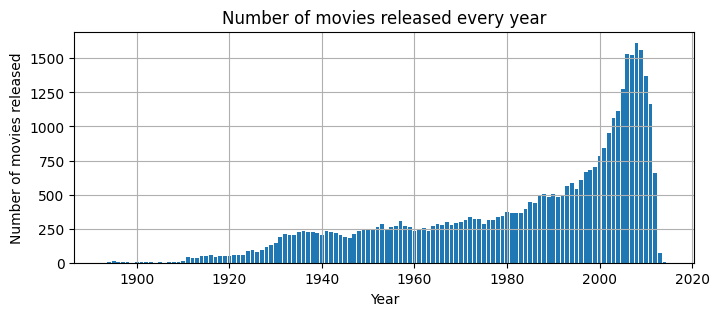

In [14]:
# Calculate the number of movies per year

movies_per_year = movies_enriched_df['date'].value_counts()


# Plot the number of movies per year

plt.figure(figsize = (8, 3))
plt.bar(movies_per_year.index, movies_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Number of movies released every year')
plt.grid(True)
plt.show()

> The dataset spans an entire century of cinema, providing a promising opportunity for our exploration of the impact specific events or movements had on society. 

### 2.3 NaN Value Analysis

> Here we analyze the NaN Values in the movies dataset, and the relevant columns in the imdb and reviews dataset.

In [15]:
# Printing NaN values, counts and percentages in the movies' dataset for further analysis

movies_nan_analysis_df = movies_enriched_df.copy()

print("MOVIES' DATASET: \n")
compute_nan_count_and_percentage(movies_nan_analysis_df)

MOVIES' DATASET: 

id_wiki: 0 NaN values, which represents 0.00 % of the column.

id_freebase: 0 NaN values, which represents 0.00 % of the column.

name: 0 NaN values, which represents 0.00 % of the column.

date: 2619 NaN values, which represents 6.20 % of the column.

box_office: 21006 NaN values, which represents 49.75 % of the column.

runtime: 6626 NaN values, which represents 15.69 % of the column.

lang: 0 NaN values, which represents 0.00 % of the column.

country: 0 NaN values, which represents 0.00 % of the column.

genre: 0 NaN values, which represents 0.00 % of the column.

id_wiki_movie: 0 NaN values, which represents 0.00 % of the column.

summary: 0 NaN values, which represents 0.00 % of the column.

popularity: 21607 NaN values, which represents 51.18 % of the column.

vote_average: 21607 NaN values, which represents 51.18 % of the column.

vote_count: 21607 NaN values, which represents 51.18 % of the column.



> While the majority of our columns have a low count of NaN values, we can notice that some columns show a high proportion of NaN values in their data, such as 'box_office', 'popularity', 'vote_average' and 'vote_count'. We have decided that 50% is sufficient to represent the other 50% of movies, to show that our principle works. However, for Milestone 3, we will have to evaluate whether to import a more complete dataset.

In [16]:
# Printing NaN values, counts and percentages in the reviews dataset for further analysis

reviews_nan_analysis_df = movies_events_reviews[['review_summary', 'review_detail']].copy()

print("REVIEWS' DATASET: \n")
compute_nan_count_and_percentage(reviews_nan_analysis_df)

REVIEWS' DATASET: 

review_summary: 38358 NaN values, which represents 90.85 % of the column.

review_detail: 38358 NaN values, which represents 90.85 % of the column.



> There is a high proportion of NaN values in reviews' data. However, we decided to pursue the emotions' assessment in reviews since we have around 4000 films with reviews and there is not many datasets on the web linking reviews' texts with movies' titles. However, we need to take this into account when drawing conclusions.

### 2.4 Number of Languages


> Here we analyze the number of languages spoken in movies.

In [17]:
# Making one big list with all instances of all languages

languages_list = []
for lang in movies_enriched_df['lang'] : languages_list += lang


# Number of different languages (tranforming the list into a set)

tot_languages = len(set(languages_list))

print('The total number of languages represented in the dataset is :', tot_languages)

The total number of languages represented in the dataset is : 208


In [18]:
# Looking for outliers contained in the "lang" column

languages_list_unique = list(set(languages_list))
print(languages_list_unique[:20])

['Oriya Language', 'Assamese Language', 'Armenian Language', 'Serbo-Croatian', 'Russian Language', 'Fula language', 'Dari', 'Sioux language', 'Cebuano language', 'Portuguese Language', 'Urdu Language', 'Finnish Language', 'Chinese, Hakka Language', 'Tagalog language', 'Deutsch', 'Cheyenne Language', 'Malayalam Language', 'Tzotzil language', 'Belarusian language', 'Arabic Language']


>We looked at each element, here are some important observations of the column 'lang':
>- Some entries are not languages in the traditional sense but rather countries such as 'France', 'Hungary' and 'Japan'
>- Important to notice is that some languages may be the same but described differently for different movies (e.g. 'german' vs 'deutsch')
>- Some languages when described in their own language use a different alphabet, e.g. '𐐖𐐲𐑉𐑋𐑌𐐲'
>- When a film is a silent film this is marked by the entry 'silent film'
>- Contains invalid values such as 'a' (this is because here we have not dropped the NAN's and 'n' and 'a' are recognized as individual languages).

### 2.5 Number of Countries and World Regions

>We analyzed the individual countries present in the dataset.
>
> We want to define different world regions, grouping different countries together in order to make data handling and visualizations easier. We could define the following regions: 
>- Europe 
>- USA + Canada 
>- Australia + Oceania
>- Middle East
>- Asia
>- Africa
>- South & Central America

In [19]:
# Obtain a list of countries contained in the dataset

only_countries = movies_enriched_df['country'].copy()
only_countries = only_countries.to_list()


# Removing all Nan's and making a onedimensional list of all countries contained in the dataset

only_countries = [x for x in only_countries if x != "NaN"]
only_countries = [item for sublist in only_countries for item in sublist]


# Creating a list with all unique countries contained in the dataset

only_countries_unique = get_unique_countries(only_countries)


print(only_countries_unique[:20])

['United States of America', 'United Kingdom', 'Germany', 'South Africa', 'Turkey', 'German Democratic Republic', 'India', 'Australia', 'New Zealand', 'Netherlands', 'Mexico', 'Canada', 'Brazil', 'Poland', 'Spain', 'Argentina', 'Japan', 'South Korea', 'Hungary', 'Pakistan']


In [20]:
# Create the corresponding regions for later analysis containing all countries from the dataset
# The individual countries come from the variable 'only_countries_unique'

europe_countries =  ['United Kingdom', 'Croatia', 'Ukraine', 'Luxembourg', 'Belgium', 'Sweden', 'Switzerland', 'Greece', 'Ireland',  'Iceland', 'Poland', 'Italy', 'Denmark',  'Scotland', 'Finland', 'Albania', 'Portugal', 'Northern Ireland', 'Austria',  'Netherlands', 'Monaco', 'Spain',  'England',  'German Democratic Republic', 'France', 'Nazi Germany', 'West Germany',  'Germany', 'Weimar Republic', 'Kingdom of Italy', 'Kingdom of Great Britain', 'Isle of Man', 'Lithuania', 'Malta', 'Czech Republic',  'Czechoslovakia', 'Slovakia', 'Romania', 'Norway', 'Serbia', 'Slovenia', 'Bulgaria', 'Slovak Republic', 'Ukrainian SSR',  'Ukranian SSR',  'Estonia',  'Soviet occupation zone', 'Bosnia and Herzegovina', 'Socialist Federal Republic of Yugoslavia', 'Yugoslavia', 'Wales', 'Hungary', 'Federal Republic of Yugoslavia',  'Serbia and Montenegro', 'Republic of Macedonia', 'Montenegro', 'Cyprus', 'Crime']
middle_east_countries = ['Lebanon', 'Iran', 'United Arab Emirates', 'Iraq', 'Turkey', 'Iraqi Kurdistan', 'Jordan', 'Mandatory Palestine', 'Palestinian territories', 'Palestinian Territories', 'Armenia', 'Georgia', 'Kuwait', 'Georgian SSR', 'Israel', 'Turkmenistan', 'Qatar', 'Bahrain', 'Azerbaijan']
asia_countries = ['Hong Kong', 'Nepal', 'Indonesia', 'China',  'Taiwan', 'Cambodia', 'Vietnam', 'Sri Lanka', 'Singapore', 'Thailand', 'Mongolia', 'Korea', 'India', 'Malaysia', 'South Korea', 'Philippines', 'Republic of China', 'Japan',  'Soviet Union', 'Bangladesh', 'Russia', 'Pakistan', 'Uzbekistan', 'Afghanistan', 'Macau', 'Uzbek SSR', 'Bhutan', 'Burma']
africa_countries = ['Guinea', 'Cameroon', 'Democratic Republic of the Congo', 'Tunisia', 'Congo', 'Ethiopia', 'Nigeria', 'Libya', 'Zimbabwe', 'Morocco',  'Mali', 'Egypt', 'Burkina Faso', 'Senegal', 'Kenya', 'South Africa', 'Algeria', 'Zambia', 'Guinea-Bissau']
south_central_america_countries =  ['Mexico', 'Colombia', 'Uruguay', 'Puerto Rico',  'Costa Rica', 'Chile', 'Venezuela', 'Peru', 'Bolivia', 'Brazil', 'Cuba', 'Panama', 'Argentina', 'Haiti', 'Bahamas', 'Jamaica', 'Aruba']
north_america_countries = ['United States of America', 'Canada']
australia_countries = ['Australia', 'New Zealand']
outlier_countries = [ 'German Language', 'Malayalam Language'] 


# Check that all countries in the dataset are contained in a certain region


all_countries = europe_countries + middle_east_countries + asia_countries + africa_countries + south_central_america_countries + north_america_countries + australia_countries + outlier_countries
print('Number of countries in the newly defined world regions:',len(only_countries_unique))
print('Number of countries in the dataset:', len(all_countries))

Number of countries in the newly defined world regions: 147
Number of countries in the dataset: 147


>A movie can be produced by multiple countries at the same time
>
> In the entries of some countries, there are typos or different syntax which is why these countries are not considered identical. To avoid any effects this can have, all manners of which the country was written was included in the grouping. Examples of this are:
> - “Ukrainian SSR” vs “Ukranian SSR”
> - “Socialist Federal Republic of Yugoslavia” vs “Yugoslavia” vs “Federal Republic of Yugoslavia”
>- “Palestinian territories” vs “Palestinian Territories”
>
>There are a few entries which do not correspond to countries. These were grouped into the list "outlier_countries" and will not be used for country analysis, as we cannot be completely sure what countries produced them. Examples of this are:
> - “German Language”
>  - “Malayalam Language”

> In order to facilitate access to the world regions we add them to the dataset.

In [21]:
regions = {'europe_countries': europe_countries, 'middle_east_countries': middle_east_countries, 'asia_countries': asia_countries, 
           'africa_countries': africa_countries, 'south_central_america_countries': south_central_america_countries, 'north_america_countries': north_america_countries, 'australia_countries': australia_countries, 'outlier_countries': outlier_countries}


# Create a new column 'world_region' in the DataFrame

movies_with_regions = movies_enriched_df.copy()
movies_with_regions['world_region'] = movies_with_regions['country'].apply(find_region, regions = regions)
movies_with_regions.sample()

,id_wiki,id_freebase,name,date,box_office,runtime,lang,country,genre,id_wiki_movie,summary,popularity,vote_average,vote_count,world_region
1296,33314767,/m/0bd646l,Code Name: Diamond Head,1977.0,0.0,74.0,[English Language],[United States of America],"[Action, Spy]",33314767,Johnny Paul arrives in Oahu disguised as a fl...,0.000308,1.5,2.0,north_america_countries


> Now, we can plot the number of movies released for each world region over the years.

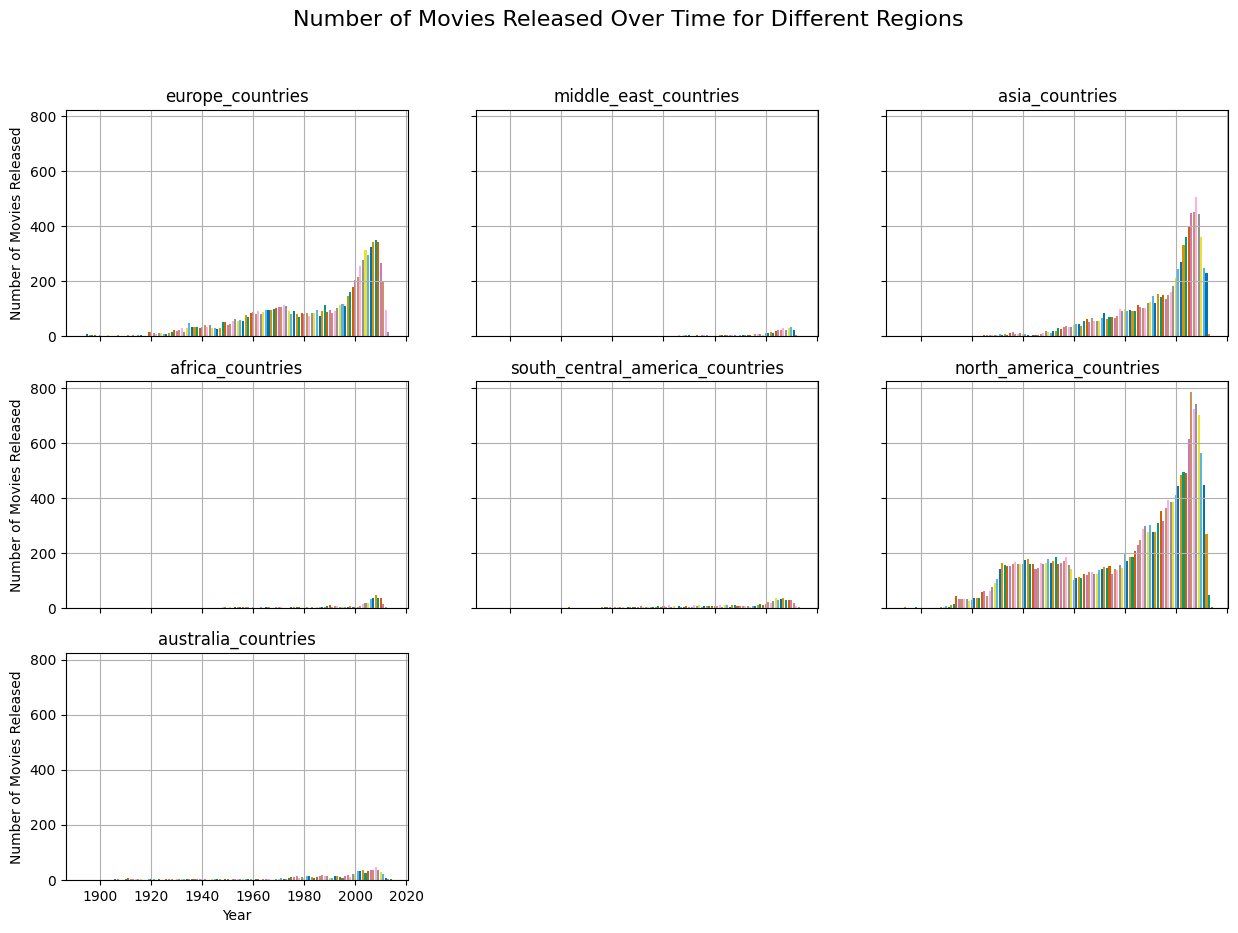

In [22]:
# Create subplots

fig, axs = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Number of Movies Released Over Time for Different Regions', fontsize=16)
color_palette = sns.color_palette("colorblind")

# Iterate over regions and plot the number of movies released over time

for (region, countries), ax in zip(regions.items(), axs.flatten()):
    filtered_movies = movies_with_regions[movies_with_regions['country'].apply(lambda x: any(item in x for item in countries))]
    movies_per_year = filtered_movies['date'].value_counts().sort_index()
    ax.bar(movies_per_year.index, movies_per_year.values, color=color_palette)
    ax.set_title(region)


# Subplots layout

for ax in axs.flat:
    ax.set(xlabel='Year', ylabel='Number of Movies Released')
    ax.grid(True)
    ax.label_outer()

fig.delaxes(axs[2][2])
fig.delaxes(axs[2][1])

plt.show()

> North American, European, and Asian countries are the top three producers in this dataset. The Middle East, Africa, South America and Australia exhibit lower film production.

### 2.6 Number of Genres and Genre Categories

>We analyzed the individual countries present in the dataset. 
>
>We want to define different genre categories, grouping different movie genres together in order to make data handling and visualizations easier.

In [23]:
# Explode the 'genre' column to create individual rows for each genre

movies_dataframe_genre = movies_with_regions.explode('genre').copy()


# Check how many unique genre we have

unique_genres = movies_dataframe_genre['genre'].unique()
print('Total number of unique genres : ',unique_genres.shape[0])
print('Examples of genres are : ', unique_genres[:10])

Total number of unique genres :  364
Examples of genres are :  ['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Erotic thriller' 'Psychological thriller' 'Drama']


> Since there are 364 different genres, we decided to create genre categories in order to better understand and visualize the genre column more easily.

In [24]:
# Defining overcategories of genres

action = ['Action', 'Action Comedy', 'Action Thrillers', 'Action/Adventure', 'Film noir', 'Neo-noir', 'Ninja movie', 'Superhero', 'Superhero movie', 'Samurai cinema','Apocalyptic and post-apocalyptic fiction', 'Doomsday film', 'Movies About Gladiators', 'Spy']
adult = ['Adult', 'Erotic Drama', 'Erotic thriller', 'Erotica', 'Gay pornography', 'Hardcore pornography', 'Homoeroticism', 'Pinku eiga', 'Pornographic movie', 'Pornography', 'Softcore Porn'] 
adventure = ['Action/Adventure', 'Adventure', 'Adventure Comedy', ' Costume Adventure', 'Family-Oriented Adventure', 'Fantasy Adventure', 'Sci-Fi Adventure', 'Wuxia']
animation = ['Animated Musical', 'Animated cartoon', 'Animation', 'Anime', 'Clay animation', 'Computer Animation', 'Silhouette animation', 'Stop motion']
comedy = ['Action Comedy', 'Adventure Comedy', 'Black comedy', 'Comdedy', 'Comedy', 'Comedy Thriller', 'Comedy Western', 'Comedy film', 'Comedy horror', 'Comedy of Errors', 'Comedy of manners', 'Comedy-drama', 'Crime Comedy', 'Domestic Comedy', 'Ealing Comedies', 'Fantasy Comedy', 'Gross out', 'Gross-out film', 'Heavenly Comedy', 'Horror Comedy', 'Humour', 'Media Satire', 'Musical comedy', 'Parody', 'Political satire', 'Romantic comedy', 'Satire', 'Screwball comedy', 'Sex comedy', 'Slapstick', 'Stand-up comedy', 'Tragicomedy', 'Workplace Comedy']
crime = ['Biker Film', 'Buddy cop', 'Crime', 'Crime Comedy', 'Crime Drama', 'Crime Fiction', 'Crime Thriller', 'Detective', 'Detective fiction', 'Gangster Film', 'Giallo','Heist', 'Juvenile Delinquency Film', 'Law & Crime', 'Master Criminal Films', 'Mystery', 'Outlaw', 'Outlaw biker film', 'Prison', 'Prison escape', 'Prison film', 'Statutory rape', 'Whodunit']
documentary = ['Archives and records', 'Biographical film', 'Biography', 'Biopic [feature]','Culture & Society', 'Essay Film', 'Docudrama', 'Documentary', 'Education', 'Mondo film', 'Educational', 'Environmental Science', 'Film & Television History', 'Finance & Investing', 'Health & Fitness', 'Historical Documentaries', 'Journalism', 'Language & Literature', 'Libraries and librarians', 'Linguistics', 'Media Studies', 'Mockumentary','Natural disaster', 'Nature', 'News', 'Political Documetary', 'Rockumentary', 'Travel', 'World History']
drama = ['Addiction Drama', 'Cavalry Film', 'Childhood Drama', 'Comedy-drama', 'Costume drama', 'Crime Drama', 'Docudrama', 'Drama', 'Erotic Drama', 'Family Drama', 'Fantasy Drama', 'Historical drama', 'Illnesses & Disabilities', 'Inspirational Drama', 'Legal drama', 'Marriage Drama', 'Melodrama', 'Medical fiction', 'Musical Drama', 'Political drama', 'Romantic drama', 'Tragedy']
family_and_children = ['Animals', 'Buddy Picture', 'Buddy film', 'Camp', "Children's", "Children's Entertainment", "Children's/Family", 'Christmas movie', 'Coming of age', 'Coming-of-age film','Dance', 'Family & Personal Relationships', 'Family film', 'Holiday Film', 'Interpersonal Relationships', 'Jukebox musical', 'Jungle Film', 'Backstage musical', 'Musical', 'Roadshow theatrical release', 'School story']
fantasy = ["Children's Fantasy", 'Creature Film', 'Fairy tale', 'Fantasy', 'Fantasy Adventure', 'Fantasy Comedy', 'Fantasy Drama', 'Heaven-Can-Wait Fantasies', 'Mythological Fantasy', 'Monster', 'Monster movie', 'Revisionist Fairy Tale', 'Romantic fantasy', 'Supernatural', 'Sword and sorcery', 'Sword and sorcery films', 'Vampire movies', 'Werewolf fiction', 'Zombie Film']
history = ['Archaeology', 'Archives and records', 'Avant-garde', 'British Empire Film', 'Cold War', 'Film & Television History', 'Gulf War', 'Hagiography', 'Historical drama', 'Historical Epic', 'Historical fiction', 'History', 'Movies About Gladiators', 'Period piece', 'Plague', 'Samurai cinema', 'Sword and Sandal', 'The Netherlands in World War II', 'World History']
horror = ['Comedy horror', 'Costume Horror', 'Demonic child', 'Gothic film', 'Haunted House Film', 'Horror', 'Horror Comedy', 'Natural horror films', 'Period Horror', 'Psycho-biddy', 'Psychological horror', 'Road-Horror', 'Sci-Fi Horror', 'Slasher', 'Splatter film', 'Supernatural', 'Zombie Film', 'Z movie']
oldies = ['Black-and-white', 'Goat gland', 'Silent film', 'Pre-Code']
romance = ['Chick flick','Romance Film', 'Romantic comedy', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller']
science_fiction = ['Alien Film', 'Alien invasion','Computers', 'Dystopia', 'Future noir', 'Inventions & Innovations', 'Sci Fi Pictures original films', 'Sci-Fi Adventure', 'Sci-Fi Horror', 'Sci-Fi Thriller', 'Science Fiction', 'Science fiction Western', 'Tokusatsu', 'Space opera', 'Space western', 'Time travel']
thriller = ['Action Thrillers', 'Chase Movie', 'Comedy Thriller', 'Crime Thriller', 'Political thriller', 'Psychological thriller', 'Romantic thriller', 'Sci-Fi Thriller', 'Thriller']
war = ['Anti-war', 'Anti-war film', 'Cold War', 'Combat Films', 'Gulf War', 'Nuclear warfare', 'Private military company', 'The Netherlands in World War II', 'War effort', 'War film']
western = ['Acid western', 'B-Western', 'Comedy Western', 'Epic Western', 'Hybrid Western', 'Indian Western', 'Revisionist Western', 'Science fiction Western', 'Singing cowboy', 'Space western', 'Spaghetti Western', 'Western']
lgbtq_and_gender = ['Feminist Film', 'Gay',  ' Gay Interest', 'Gay Themed', 'Gay pornography', 'Gender Issues', 'Homoeroticism', 'LGBT', 'New Queer Cinema', 'Women in prison films']

number_genres_considered = action + adult + adventure + animation + comedy + crime + documentary + drama + family_and_children + fantasy + history + horror + oldies + romance + science_fiction + thriller + war + western + lgbtq_and_gender
print('The ratio of genres considered', len(number_genres_considered), '/', unique_genres.shape[0])


# Check how many movies are covered by these genres

represented_movies = movies_dataframe_genre[movies_dataframe_genre['genre'].apply(lambda x: any(item in x for item in number_genres_considered))]
represented_movies_unique = represented_movies['name'].unique()
print('Movies considered:', len(represented_movies_unique), 'out of', movies_with_regions.shape[0])

The ratio of genres considered 292 / 364
Movies considered: 38351 out of 42220


> We decided to retain only a subset of genres, specifically a ratio of 292 out of 364 possible genres. 
>
>Some genres in the dataset are irrelevant for a study on society, such as 'Short Films', which essentially represent a distinct movie categorization rather than a genre.
>
> Due to this, however, a significant number of movies fall outside the scope of the considered genres. We made an effort to include as many genres in the list as possible while maintaining as much objectivity as possible. For example, the genre 'Heist' could be part of the 'drama', 'comedy' or 'crime' categories. However, the only one of these where it will always be part of is the 'crime' category so we only matched it to this one.
>
>Additionally, there are genres that encompass two of our selected overarching genres, such as 'Adventure Comedy.' In these cases, we added them to both overarching genres. 

> In order to facilitate access to the world regions we add them to the dataset. The movies not considered in our study will have a NaN value in this new column.

In [25]:
genres_considered = {'action': action, 'adult': adult, 'adventure': adventure, 'animation': animation, 'comedy': comedy, 'crime': crime, 'documentary': documentary, 'drama': drama, 'family_and_children': family_and_children, 'fantasy': fantasy, 'history': history, 'horror': horror, 'oldies': oldies, 'romance': romance, 'science_fiction': science_fiction, 'thriller': thriller, 'war': war, 'western': western, 'lgbtq_and_gender': lgbtq_and_gender}


# Add a new column to the main dataframe to store the names of the genres and make them easily accessible

movies_with_genre = movies_with_regions.copy()
movies_with_genre['new_genre'] = None


# Iterate over genres_considered and update the 'new_genre' column

for name, genre_list in genres_considered.items():
    mask = movies_with_genre['genre'].apply(lambda x: any(item in x for item in genre_list))
    movies_with_genre.loc[mask, 'new_genre'] = movies_with_genre.loc[mask, 'new_genre'].apply(lambda x: [] if x is None else x)  # Initialize with an empty list if None
    movies_with_genre.loc[mask, 'new_genre'] = movies_with_genre.loc[mask, 'new_genre'].apply(lambda x: x + [name] if isinstance(x, list) else [name])
    
movies_with_genre.sample()

,id_wiki,id_freebase,name,date,box_office,runtime,lang,country,genre,id_wiki_movie,summary,popularity,vote_average,vote_count,world_region,new_genre
20081,3213541,/m/08zr0g,The Virgin Queen,1955.0,0.0,92.0,[English Language],[United States of America],"[Costume drama, Period piece, Drama, Romantic ...",3213541,"In 1581, Walter Raleigh , recently returned fr...",0.728698,7.8,4.0,north_america_countries,"[documentary, drama, history, romance]"


> Now, we can plot the distributions of genre categories over time. We have chosen to group them by decade for better visualization.

/tmp/ipykernel_1338/2644135897.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Paired', len(genre_counts.columns))


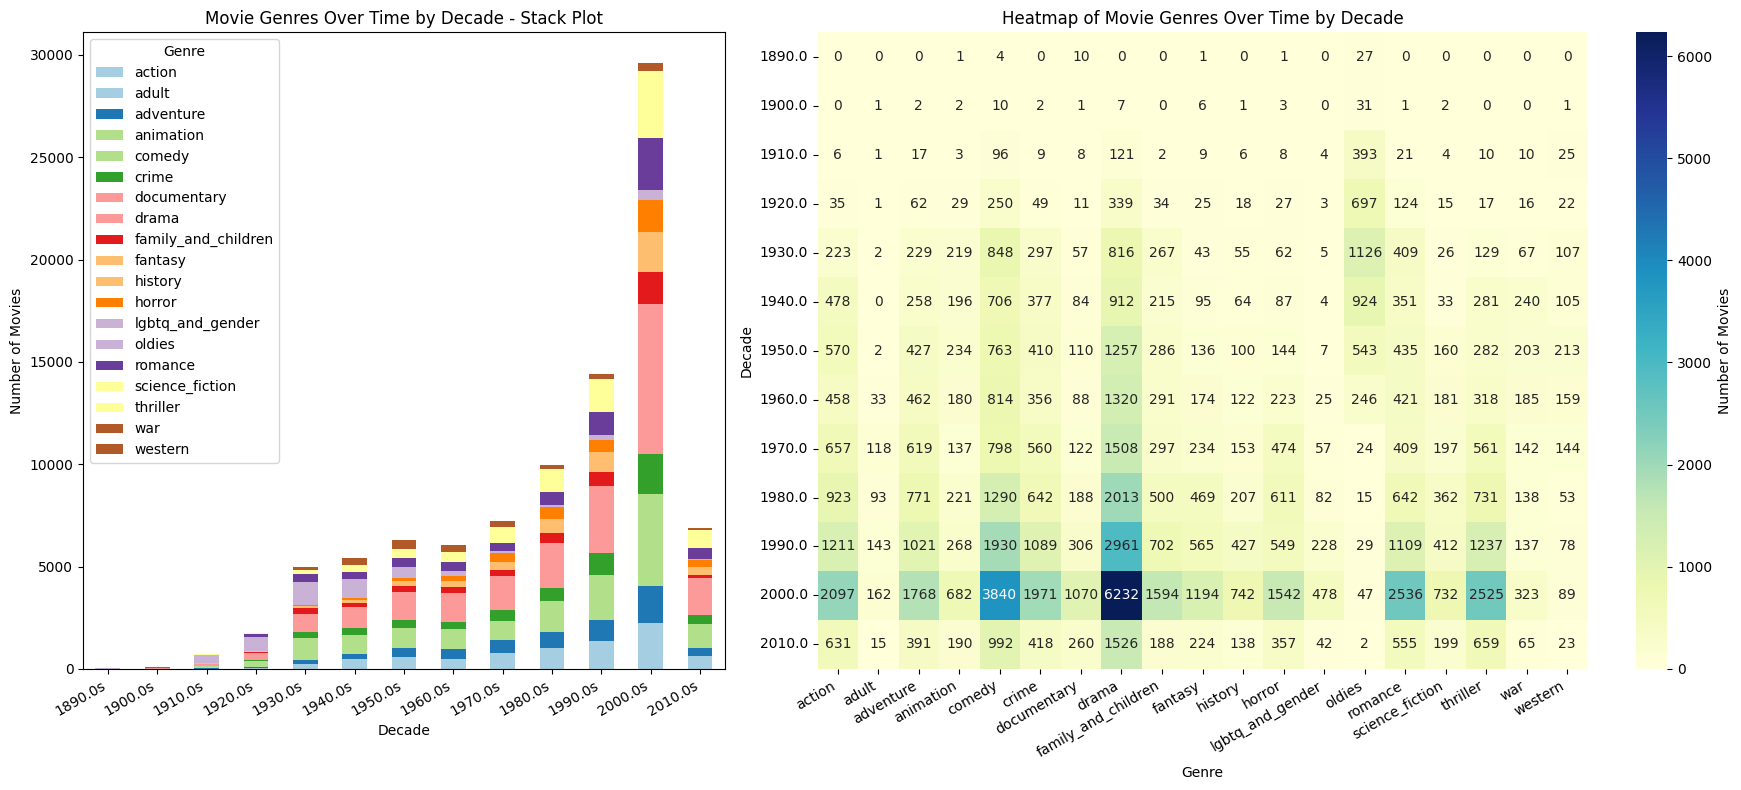

In [26]:
movies_dataframe = movies_with_genre.copy()


# Create a new column representing the corresponding decade of each movie for easier plotting

movies_dataframe['decade'] = (movies_dataframe['date'] // 10) * 10


# Count occurrences of each genre per decade

df_stacked = movies_dataframe[['decade', 'new_genre']].explode('new_genre')
genre_counts = df_stacked.groupby(['decade', 'new_genre']).size().unstack(fill_value=0)


# Plot

fig, axes = plt.subplots(1, 2, figsize = (18, 8), gridspec_kw = {'width_ratios': [2, 3]})

cmap = cm.get_cmap('Paired', len(genre_counts.columns))
colors = {genre: cmap(i) for i, genre in enumerate(genre_counts.columns)}

genre_counts.plot(kind = 'bar', stacked = True, ax = axes[0], color = colors)
x_labels = ['{}s'.format(decade) for decade in genre_counts.index]
axes[0].set_xticklabels(x_labels, rotation = 30, ha = 'right')
axes[0].set_title('Movie Genres Over Time by Decade - Stack Plot')
axes[0].set_xlabel('Decade')
axes[0].set_ylabel('Number of Movies')
axes[0].legend(title='Genre', loc='upper left')

sns.heatmap(genre_counts, cmap = "YlGnBu", annot = True, fmt = 'd', cbar_kws = {'label': 'Number of Movies'}, ax = axes[1])
axes[1].set_title('Heatmap of Movie Genres Over Time by Decade')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Decade')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = 30, ha = 'right')

plt.tight_layout()
plt.show() ;

> The overall number of movies has increased across decades, but variations exist among individual genres. Notably, the 'oldies' genre, encompassing silent and black-and-white films, shows a decline in its production proportion compared to other genres.
>
>Given that the dataset extends only until 2016, the observed general decrease in the number of movies for the last plotted decade might be influenced by the incomplete data for the most recent years.

## 3. Movies Association to Historical Events and Movements

> The focus of our project is to study how impactful historical events and movements are by analyzing movies. Initially, we attempted to categorize the movies to events based on their genres. However, leading our study solely according to the genres to which the movies belong to seems quite challenging, as genres may not accurately reflect historical events. 
>
> As a result, we have decided to adopt another approach by mapping movies to the historical events they correspond to through a keyword search in their plot summaries. The keywords specific to each event are defined in event-related dictionaries we created.
>
> In this part we will define our dictionaries, associate the movies in our dataset to the different events using these dictionaries and evaluate the quality of our dictionary-based classification model.

### 3.1 Creation of Dictionaries

> We decided to focus our study on several different events and movements that dominated the past century: 
>- World War 1
>- World War 2
>- Space race
>- The Cold War
>- The Vietnam War
>- Women emancipation
>- Black history
>- Digitalisation
>- Sexuality
>- The emergence of STDs
>- Drug Abuse
>- Destigmatizing Mental Health
>- The Atomic Bomb
>- The emergence of Genetic Engineering
>- LGBTQ emancipation
>- Terrorism
>
>The dictionaries were manually defined in the file [dictionaries.py](dictionaries.py). In order to make handling the dictionaries easier, we stored them in a *.csv* file [dictionaries.csv](data/AdditionalDatasets/dictionaries.csv). 
The dictionaries were inspired by content found on the [internet](https://www.oed.com/discover/word-lists). 
>
>Note : We tried to stay as objective and event-specific as possible but since the dictionaries were made manually we cannot exclude some potential bias.

In [27]:
# Loading of the dictionaries

DICTIONARIES_DATASET = ADDITIONAL_FOLDER + "dictionaries.csv"
dictionaries_df = pd.read_csv(DICTIONARIES_DATASET, index_col = 0)


#for easy access of the individual event names:
events = dictionaries_df.index.astype(str).tolist()


dictionaries_df.head(16)

,dictionaries
events,
WW1,world war i | world war 1 | ww1 | wwi | 1914 |...
WW2,world war ii | world war 2 | ww2 | wwii | 1939...
Space,moon landing | 1969 | apollo 11 | apollo | spa...
Cold War,nuclear arms race | iron curtain | berlin airl...
Vietnam War,vietnam war | viet cong | viet | viets | agent...
Women emancipation,feminism | suffrage | equal rights | gender eq...
Black History,black history | slavery | emancipation proclam...
Digitalisation,internet | drones | computer | mobile phone | ...
Sexuality,sexuality | gender expression | bdsm | safe se...


#### 3.1.1 Evaluation using a Test Set

##### 3.1.1.1 Test Set and Classification

> To further test the performance of our dictionary-based classification, we created a 'testing set' of movies for which we already know the corresponding event/movement. This was done manually in the file [movies-test-set.py](movies-test-set.py). To make handling of this dataset easier, we stored it in a *.csv* file : [movies_test_set.csv](data/AdditionalDatasets/movies_test_set.csv). This data was obtained from websites listing movies by category, such as [imdb](https://www.imdb.com/). We then applied our dictionary-based classification methods to this test set and compared the results with the true events of the movies.
>
> Note: the Testset will consist of 10 specific movies per event

In [28]:
# Loading of movies_test_set dataset for testing dictionaries quality

MOVIES_TEST_DATASET = ADDITIONAL_FOLDER + "movies_test_set.csv"
movies_test_set = pd.read_csv(MOVIES_TEST_DATASET, converters = {'true_event': ast.literal_eval})


# Merge movies_test_set and plot_summaries datasets

movie_plots = plot_summaries.copy()
merged_test_set_plots = pd.merge(movies_test_set, movie_plots, how = 'left', left_on = 'id_wiki', right_on = 'id_wiki_movie')


##### 3.1.1.2 Threshold Evaluation

> Our approach involves setting a threshold for each dictionary, indicating the minimum number of matching words required to classify a movie as belonging to an event. 
> Under the assumption that the dictionaries we are using are highly specific, we have set the threshold to 1 for all dictionaries. This means that one word is sufficient to match a movie plot to the corresponding event. We may adjust the thresholds later.
>
> In order to evaluate whether we should use a threshold of 1 or 2 when matching the movie plot summaries to the dictionnaries we use cross-validation.

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

In [30]:
#Create the test set using threshold = 1 and 2

dictionaries_df_1 = dictionaries_df.copy()
dictionaries_df_1['threshold'] = 1

dictionaries_df_2 = dictionaries_df.copy()
dictionaries_df_2['threshold'] = 2

# Match each movie to an event using our dictionaries

movies_test_set_events_1 = add_event_columns(merged_test_set_plots, dictionaries_df_1).copy()
movies_test_set_events_1 = create_events_belongs_to_column(movies_test_set_events_1, events).copy()

movies_test_set_events_2 = add_event_columns(merged_test_set_plots, dictionaries_df_2).copy()
movies_test_set_events_2 = create_events_belongs_to_column(movies_test_set_events_2, events).copy()


>To simplify the data handling we use one-hot encoding.

In [31]:
movie_one_hot_1 = movies_test_set_events_1.copy()
movie_one_hot_2 = movies_test_set_events_2.copy()


# One Hot encoding of the event columns
for event in events:
    movie_one_hot_1.rename(columns={event: f'{event}-onehot'}, inplace=True)
    movie_one_hot_2.rename(columns={event: f'{event}-onehot'}, inplace=True)
    

# Convertion from booleans to integers for the one-hot encoded columns

one_hot_columns_1 = [col for col in movie_one_hot_1.columns if col.endswith('-onehot')]
one_hot_columns_2 = [col for col in movie_one_hot_2.columns if col.endswith('-onehot')]

movie_one_hot_1[one_hot_columns_1] = movie_one_hot_1[one_hot_columns_1].astype(int).copy()
movie_one_hot_2[one_hot_columns_2] = movie_one_hot_2[one_hot_columns_2].astype(int).copy()


# Print the column names of the resulting dataframe

display(movie_one_hot_1.columns)

Index(['id_wiki', 'id_freebase', 'name', 'date', 'true_event', 'id_wiki_movie',
       'summary', 'WW1-onehot', 'WW2-onehot', 'Space-onehot',
       'Cold War-onehot', 'Vietnam War-onehot', 'Women emancipation-onehot',
       'Black History-onehot', 'Digitalisation-onehot', 'Sexuality-onehot',
       'STDs-onehot', 'Drug Abuse-onehot', 'Mental Health-onehot',
       'Atomic Bomb-onehot', 'Genetic Engineering-onehot', 'LGBTQ-onehot',
       'Terrorism-onehot', 'events_belongs_to'],
      dtype='object')

In [32]:
one_hot_features_1 = [col for col in movie_one_hot_1.columns if col.endswith('-onehot')]
one_hot_features_2 = [col for col in movie_one_hot_2.columns if col.endswith('-onehot')]

X_1 = numpy_helper(movie_one_hot_1, one_hot_features_1)
X_2 = numpy_helper(movie_one_hot_2, one_hot_features_2)

y_1 = movies_test_set_events_1['true_event']
y_2 = movies_test_set_events_2['true_event']


# Convert the multi-label target variable to binary matrix
mlb = MultiLabelBinarizer(classes = events)
y_1_binary = mlb.fit_transform(y_1)
y_2_binary = mlb.fit_transform(y_2)


# Generate the classification report for Model 1
report_model_1 = classification_report(y_1_binary, X_1, target_names=mlb.classes_)
print("Classification Report for Model 1:\n", report_model_1)


# Generate the classification report for Model 2
report_model_2 = classification_report(y_2_binary, X_2, target_names=mlb.classes_)
print("Classification Report for Model 2:\n", report_model_2)


Classification Report for Model 1:
                      precision    recall  f1-score   support

                WW1       0.59      1.00      0.74        10
                WW2       0.64      1.00      0.78        14
              Space       0.57      0.80      0.67        10
           Cold War       0.36      0.88      0.51        16
        Vietnam War       0.42      1.00      0.59        10
 Women emancipation       0.38      0.50      0.43        12
      Black History       0.42      0.80      0.55        10
     Digitalisation       0.36      0.69      0.47        13
          Sexuality       0.15      0.27      0.19        11
               STDs       0.53      0.69      0.60        13
         Drug Abuse       0.34      0.91      0.50        11
      Mental Health       0.47      0.57      0.52        14
        Atomic Bomb       0.63      1.00      0.77        12
Genetic Engineering       0.64      0.64      0.64        11
              LGBTQ       0.55      0.79      0.

/opt/jlab-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jlab-env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> As the numbers of movies per event vary in the test set, we focus on the f1-score which is the harmonic mean of precision and recall. We can see that not all the dictionnaries have their best f1-score. This might be because for some the movies belonging to one event one keyword is not enough to match them to an event, whereas for others the dictionary is too broad and we need to set a threshold of two. To match the movies dataset to the events we use the best threshold per event. If for one event we get the same f1-score for both thresholds, we set the threshold to 1.
>
> Furthermore we will remove sexuality from further analysis, as we do not get a good f1-score for either threshold.

In [33]:
#ONLY RUN THIS CELL ONCE
# Remove sexuality from the dictionaries and events

dictionaries_df = dictionaries_df.drop('Sexuality')
events.remove('Sexuality')
                                       
dictionaries_df.head(15)

,dictionaries
events,
WW1,world war i | world war 1 | ww1 | wwi | 1914 |...
WW2,world war ii | world war 2 | ww2 | wwii | 1939...
Space,moon landing | 1969 | apollo 11 | apollo | spa...
Cold War,nuclear arms race | iron curtain | berlin airl...
Vietnam War,vietnam war | viet cong | viet | viets | agent...
Women emancipation,feminism | suffrage | equal rights | gender eq...
Black History,black history | slavery | emancipation proclam...
Digitalisation,internet | drones | computer | mobile phone | ...
STDs,aids | hiv | human immunodeficiency virus | ac...


In [34]:
#Specify threshold for each event
dictionaries_df.at['WW1', 'threshold'] = 1
dictionaries_df.at['WW2', 'threshold'] = 2
dictionaries_df.at['Space', 'threshold'] = 1
dictionaries_df.at['Cold War', 'threshold'] = 2
dictionaries_df.at['Vietnam War', 'threshold'] = 2
dictionaries_df.at['Women emancipation', 'threshold'] = 2
dictionaries_df.at['Black History', 'threshold'] = 2
dictionaries_df.at['Digitalisation', 'threshold'] = 2
dictionaries_df.at['STDs', 'threshold'] = 2
dictionaries_df.at['Drug Abuse', 'threshold'] = 2
dictionaries_df.at['Mental Health', 'threshold'] = 1
dictionaries_df.at['Atomic Bomb', 'threshold'] = 2
dictionaries_df.at['Genetic Engineering', 'threshold'] = 1
dictionaries_df.at['LGBTQ', 'threshold'] = 1
dictionaries_df.at['Terrorism', 'threshold'] = 2

##### 3.1.1.3 Performance Statistics of the Classification 

>Using the event-matched test set, we are able to compute the number of true positives, true negatives, false positives and false negatives in our prediction. This result is shown in a confusion matrix. From this we can then compute the performance statistics of our dictionary-based matching : accuracy, precision, recall, f1 score and specificity. 

In [35]:
# Match each movie to an event using our dictionaries

movies_test_set_events = add_event_columns(merged_test_set_plots, dictionaries_df).copy()
movies_test_set_events = create_events_belongs_to_column(movies_test_set_events, events).copy()

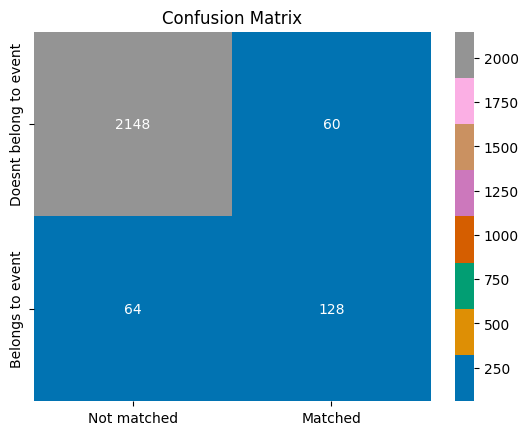

In [36]:
# Compute True Positives (TP), True Negatives (TN), False Positives (FP) and False Negative (FN) from the test sets

TP = 0
FN = 0
FP = 0
TN = 0

for index, movie in movies_test_set_events.iterrows() :  
    true_events = set(movie['true_event'])
    matched_events = set(movie['events_belongs_to'])
    
    TP += len(true_events.intersection(matched_events))
    TN += len(events) - len(true_events.union(matched_events))
    FP += len(matched_events) - len(true_events.intersection(matched_events))
    FN += len(true_events) - len(true_events.intersection(matched_events))


# Construct confusion matrix

conf_matrix = confusion_matrix(y_true=[1] * (TP + FN) + [0] * (TN + FP),
                               y_pred=[1] * TP + [0] * FN + [1] * FP + [0] * TN)


# Plot confusion matrix as a heatmap

cmap = sns.color_palette("colorblind", n_colors=8)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = cmap,
            xticklabels = ['Not matched', 'Matched'],
            yticklabels = ['Doesnt belong to event', 'Belongs to event'])

plt.title('Confusion Matrix')
plt.show()

>From this confusion matrix two things stand out :
>- there is a very large number of true negatives (2312), that is the number of movies that were correctly not matched to an event they don't correspond to.
>- there is a very small number of false negatives (44), that is movies that were not matched to any event when they should have been matched.
>
>However these numbers are less extreme for true positives (116) and false positives (176), which is not a result we want. This indicates that among movies that were matched to an event, about half does not actually belong to that event. 
>
>These are good results, since ideally we would want the number of true positives and true negatives to be high and the number of false positives and false negatives to be low.
>
>The goal for milestone 3 is to optimize the dictionaries and the matching process in order to have more true positives and less false positives.


In [37]:
# Performance metrics

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)

print('Statistics of our dictionary-based prediction model:')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 score: ', f1)
print('Specificity: ', specificity)

Statistics of our dictionary-based prediction model:
Accuracy:  0.9483333333333334
Precision:  0.6808510638297872
Recall:  0.6666666666666666
F1 score:  0.6736842105263158
Specificity:  0.9728260869565217


> Now, with these performance scores on the test set, we can further understand the validity of our method to match a movie to a specific event. The accuracy, specificity, and recall are quite high, indicating robust performance. However, the lower precision and F1 score suggest that, despite a good rate of true negatives, we lack precision. We have more False Positives than True Positives, which doesn't yield a good ratio.
>
> To address this issue, we might consider further testing of our dictionaries for milestone 3. 
>One way to optimize this would be to identify which event-dictionaries are too sensitive. This could be done by examining these different measures while excluding one 'event' dictionary at a time and then change the threshold of minimum matching words accordingly.

### 3.2 Match Movie to Event

> After the matching, we check the number of movies matched to each event to make sure we have enough movies for the analysis to be representative.

In [57]:
# This cell takes a little bit of time to run (around 4 minutes)


movies_events_df = movies_with_genre.copy()


# Matching each movie to one or multiple events

movies_events_df = add_event_columns(movies_events_df, dictionaries_df)
movies_events_df = create_events_belongs_to_column(movies_events_df, events)


# Creating a copy that we can use for further analyses (part 4) 

movies_events = movies_events_df.copy()

In [39]:
# Checking how many movies were associated to an event

movies_with_events_only = movies_events_df[movies_events_df[events].any(axis=1)].copy()
print('Number of movies that were successfully matched to at least one event : ', movies_with_events_only.shape[0])

movies_with_events_only.head(3)

Number of movies that were successfully matched to at least one event :  8136


,id_wiki,id_freebase,name,date,box_office,runtime,lang,country,genre,id_wiki_movie,...,Black History,Digitalisation,STDs,Drug Abuse,Mental Health,Atomic Bomb,Genetic Engineering,LGBTQ,Terrorism,events_belongs_to
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",975900,...,False,False,False,False,False,False,False,False,False,[Space]
6,18296435,/m/04cqrs4,Aaah Belinda,1986.0,NaN,NaN,[Turkish Language],[Turkey],[Comedy],18296435,...,False,False,False,False,True,False,False,False,False,[Mental Health]
7,11250635,/m/02r52hc,The Mechanical Monsters,NaN,NaN,NaN,[English Language],[United States of America],"[Science Fiction, Adventure, Animation, Short ...",11250635,...,False,True,False,False,False,False,False,False,False,[Digitalisation]


>More than 12,000 movies out of 42,000 were selected to represent one or more historical events.

In [40]:
# Number of movies matched for each event

movies_per_event = {}

print('Number of movies matched to each event:')


# Iterate through each event

for event in events:
    movies_per_event[event] = movies_events_df[movies_events_df['events_belongs_to'].apply(lambda x: event in x)]

    print(f'{event}:', movies_per_event[event].shape[0])  

Number of movies matched to each event:
WW1: 828
WW2: 833
Space: 740
Cold War: 447
Vietnam War: 344
Women emancipation: 128
Black History: 288
Digitalisation: 634
STDs: 105
Drug Abuse: 716
Mental Health: 1980
Atomic Bomb: 346
Genetic Engineering: 525
LGBTQ: 1373
Terrorism: 532


>Looking at these numbers, we concluded that we have enough movies for each event-category to conduct a meaningful analysis.
>However, we should keep in mind that our dictionaries might be biased, which could also be reflected in the number of movies for each event. 

### 3.3 Quality Check of Dictionaries


>Now that we checked that the dictionary-based classification works, it is important to test the precision and accuracy of this categorization.
>
>To check how specific our dictionaries are, we will first look at the correlation between the different dictionaries and the number of movies that belong to two events at the same time. Keep in mind that this measure is not necessarily unwanted, as some movies might simply cover multiple topics. 
>
>Then we will test our dictionary-based classification on a subset of movies for which we know the corresponding event. This will allow us to assess the overall performance of our categorization through statistics that take into account False Positives, True Positives, False Negatives, and True Negatives.

#### 3.3.1 Correlation Matrix

>To evaluate our dictionaries, we create a correlation matrix using Pearson's Correlation. By doing this, we aim to ensure that no two dictionaries are too strongly correlated, which would indicate a lack of specificity. However, it is worth noting that some correlation might still make sense between two events, for example, for the events "Cold War" and "Vietnam War".

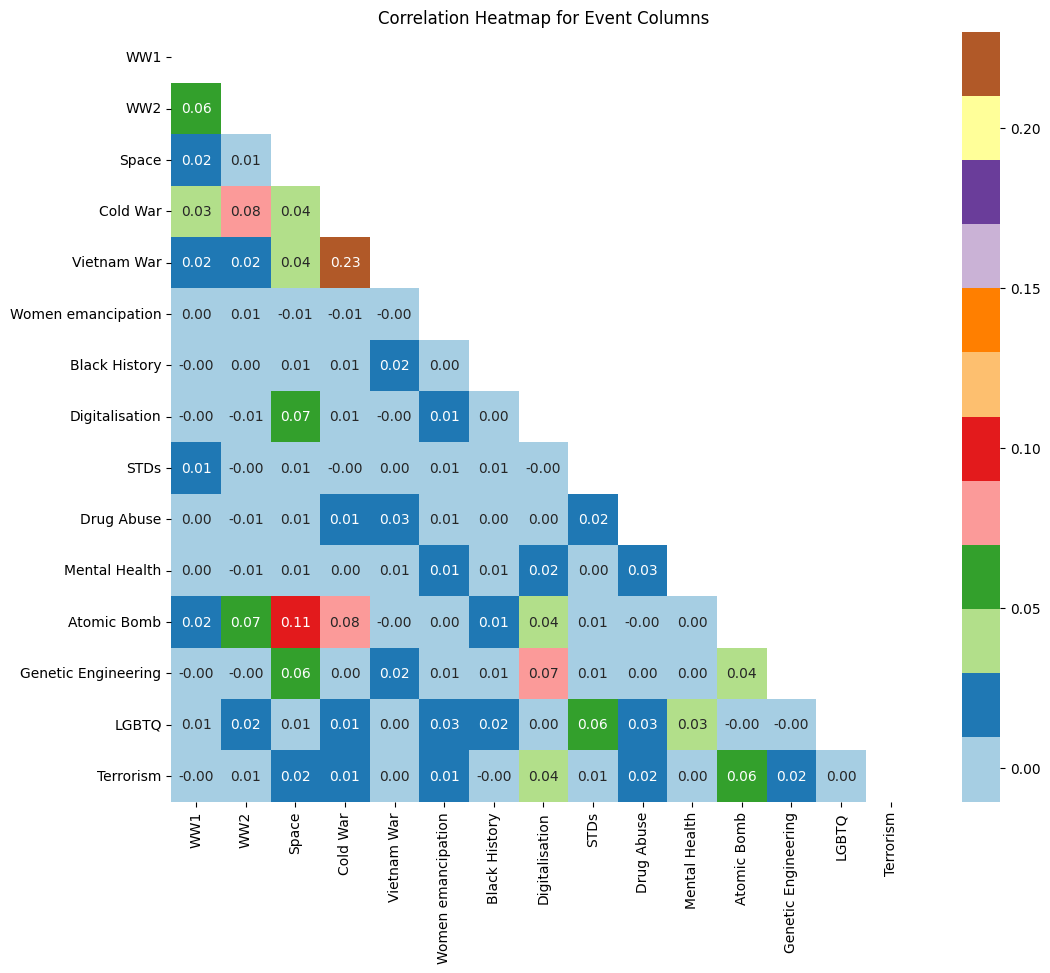

In [41]:
df = movies_events_df.copy()


# Create a correlation matrix

df[events] = df[events].astype(int)
correlation_matrix = df[events].corr()


# Create a mask for the upper triangle to reduce computation time

mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))


# Plot the correlation matrix

plt.figure(figsize = (12, 10))
sns.heatmap(correlation_matrix, annot = True, cmap = 'Paired', fmt = ".2f", mask = mask)
plt.title("Correlation Heatmap for Event Columns")
plt.show()

>When looking at this correlation map, the most shared events among pairwise combinations of movies are:
>
>- Atomic Bomb & WW2
>- Atomic Bomb & Space
>- Cold War & Atomic Bomb
>- Cold War & Vietnam War
>- Sexuality & LGBTQ
>
>That is reasonable because those events are pairwise related. However, it is still a bit tricky to analyze because we cannot exclude that the dictionaries might still be too similar, which could explain some of the strong correlation between the events, for example LGBTQ and Sexuality.

#### 3.3.2. Movies Shared Between Two Events

>To represent the correlation in a more intuitive way, we plotted the number of movies two events share on a heatmap.

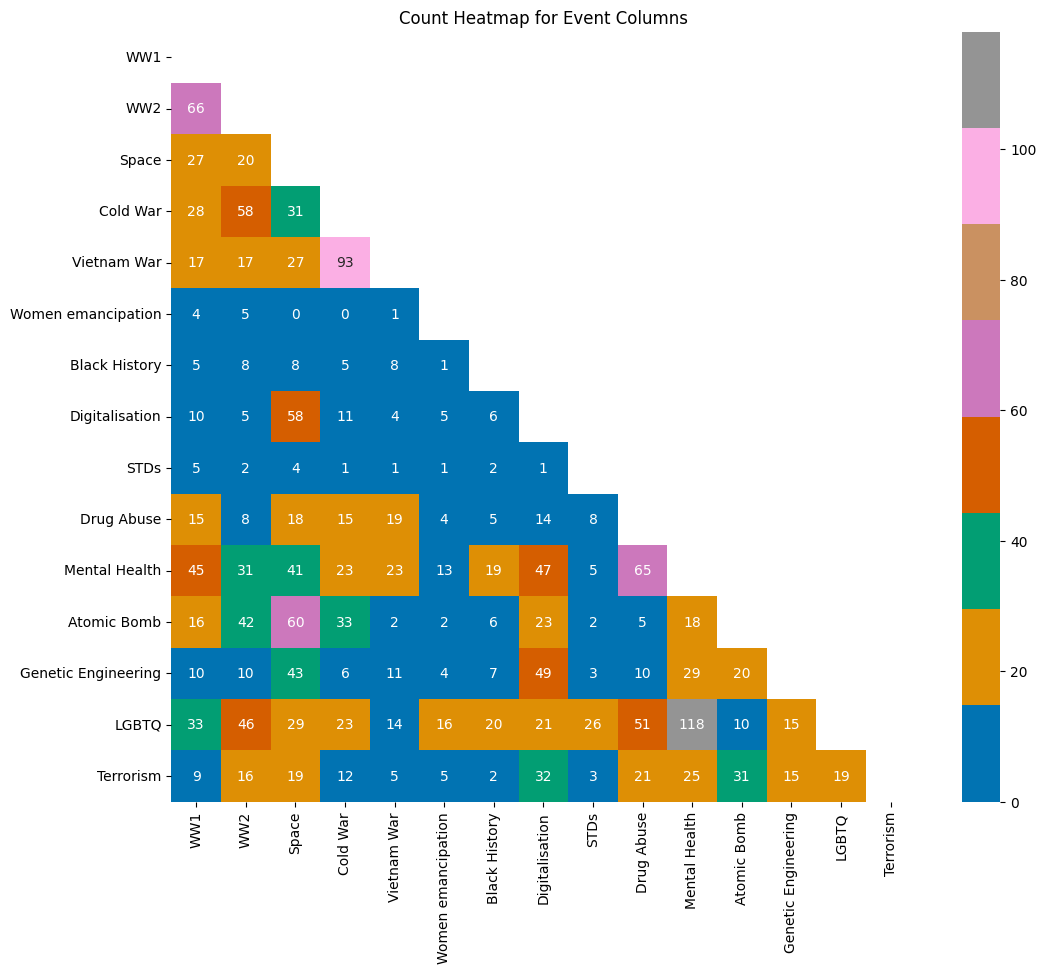

In [42]:
# Create a DataFrame with counts of occurrences of events

count_matrix = df[events].T.dot(df[events])


# Create a mask for the upper triangle to reduce computation time

mask = np.triu(np.ones_like(count_matrix, dtype=bool))


# Plot the heatmap

plt.figure(figsize=(12, 10))
cmap = sns.color_palette("colorblind", n_colors=8)
sns.heatmap(count_matrix, annot=True, cmap=cmap, fmt="d", mask=mask)

plt.title("Count Heatmap for Event Columns")
plt.show()

>When looking at this heatmap, the most shared events among pairwise combinations of movies are:
>
>- WW2 & WW1
>- Atomic Bomb & WW2
>- Cold War & WW2
>- Sexuality & LGBTQ
>- Sexuality & Opioid Crisis.
>
> These are reasonable shared events per movie, and we can say that our dictionary method seems reasonable overall.
> 
> We see that some of the high numbers in the heatmap are not in the correlation matrix. This may be because here we only look at the number of shared movies while ignoring the other correlations, which shows other interesting interactions.


## 4. Diving into the Analysis of Events

> Now that we matched the movies to specific historical event/movement we can start to analyze if we can study our research questions for each parameter.

#### 4.1 Number of Movies per Event Over the Years

> In this section, we plot the number of movies for each event per year. This not only shows which events are more popular and 'more interesting' to society but also serves as additional testing for our dictionary-based event classification. For example, we don't expect movies about WW2 to occur before 1939.

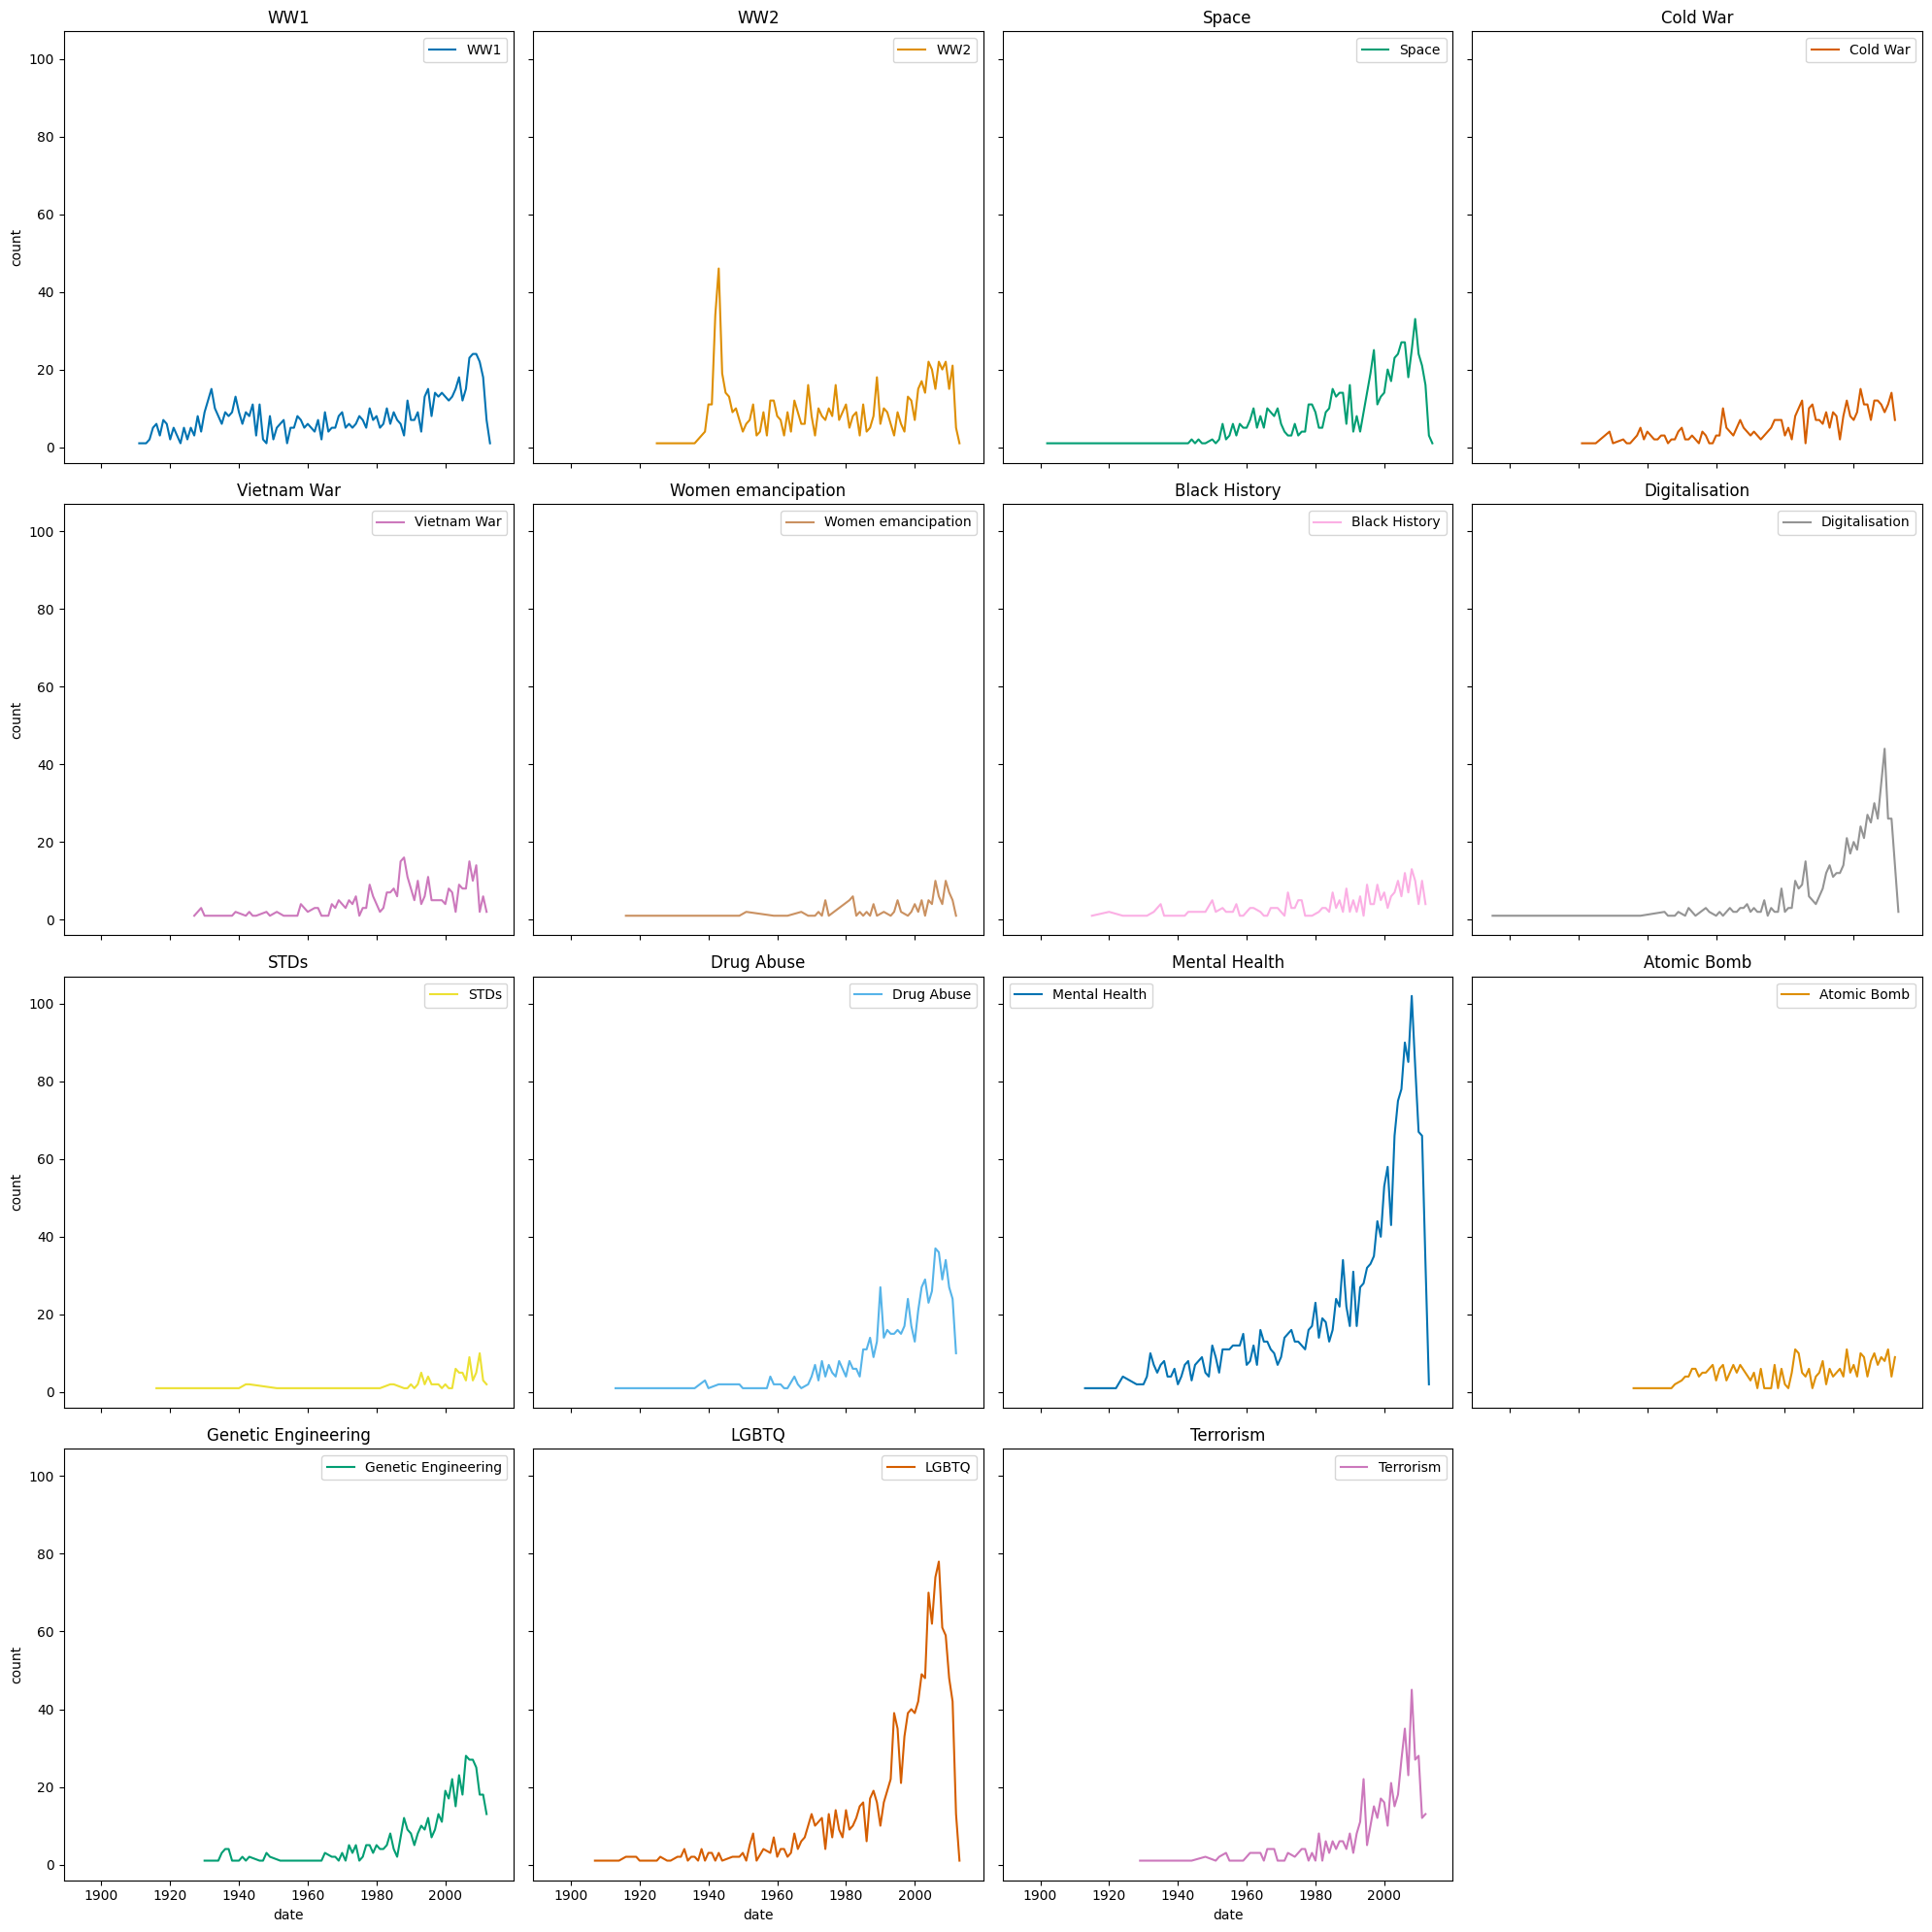

In [43]:
plot_events_over_years(movies_events, events, figures_per_row = 4)

> We can observe that the representation of all events in cinema shows an increase throughout the century. However, this can also be linked to the fact that the movie industry also experienced significant growth. In section 2, we created a similar plot where indeed the number of movies in the entire dataset has increased significantly over the years.
>
> Additionally, we can check the timeline for each event's movie releases, and they seem coherent overall. We can see that most WW2 movies were not released before 1940, which is reassuring. The same is true for the production of Vietnam War movies, which started to increase around 1970.

>ANOVA test to compare the different events regarding the percentage of movies produced each year:

In [44]:
event_percentage = {event: get_year_percentage(movies_events, event) for event in events}


# Extract values from the dictionary for each event

samples_unified = list(event_percentage.values())


# ANOVA test

result_ANOVA = f_oneway(*samples_unified)

print("F-statistic:", result_ANOVA.statistic)
print("P-value:", result_ANOVA.pvalue)

F-statistic: 30.974757179790522
P-value: 1.5318746718480173e-74


> The p-value is very small, indicating significant evidence to reject the null hypothesis. This suggests that all the events mean proportions over the years are different from eachother.

#### 4.2 Number of Countries Producing a Movie Matched to an Event

>One measure of the impact a historical event had, is to see how the event was experienced internationally. By looking at the number of countries that produced a movie about a specific event we plan to see how impactful this specific event was.

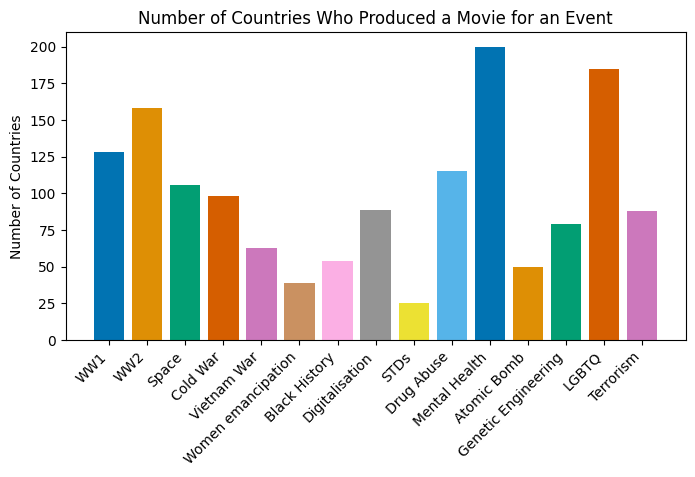

In [45]:
# Count the number of unique countries that produced a movie concerning a specific event

dataframes_events = []
for event in events:
    dataframes_events.append(movie_affected_to_event(movies_events, event))
unique_country_counts = [df['country'].apply(tuple).nunique() for df in dataframes_events]    


# Create a bar plot

fig, ax = plt.subplots(figsize=(8, 4))
color_palette = sns.color_palette("colorblind")  # Define a custom color palette
bar_width = 0.8
bar_positions = np.arange(len(events))
ax.bar(bar_positions, unique_country_counts, bar_width, color = color_palette , align = 'center')
ax.set_xticks(bar_positions)
ax.set_xticklabels(events, rotation = 45, ha = 'right')
ax.set_ylabel('Number of Countries')
ax.set_title('Number of Countries Who Produced a Movie for an Event')

plt.show()

In [46]:
# Calculate the coefficient of variation
cv = np.std(unique_country_counts) / np.mean(unique_country_counts)

print(f'Coefficient of Variation: {cv:.3f}')
print(f'Standard Deviation: {np.std(unique_country_counts):.3f}')

Coefficient of Variation: 0.509
Standard Deviation: 50.093


>We can see that the coefficient of variation and the standard deviation are high (CoV higher than 0.3). This could indicate that the number of countries that produced a movie about a specific event varies to a certain degree. In order to take any conclusions we should explore the distribution of the data further in Milestone 3.

#### 4.3 Box office revenue

>Another measure of an event's impact could be the box office revenue, which gives us a quantifiable measure of how many people went to watch a movie dealing with a specific event or movement.

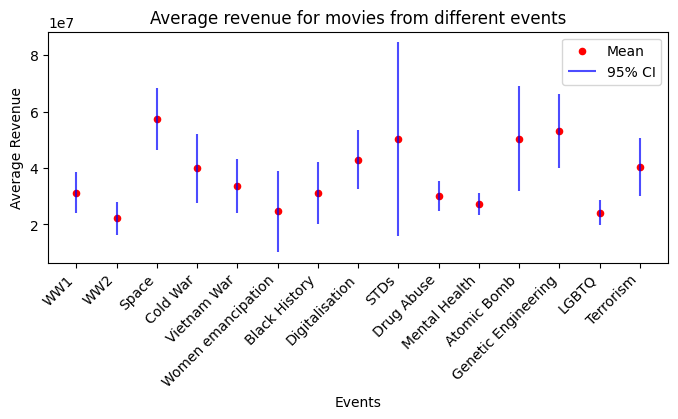

In [47]:
# Represent the different box office revenues in a scatterplot

all_averages = []
all_conf_intervals = []

for i, element in enumerate(events):
    element_events = movie_affected_to_event(movies_events, element)
    element_revenue = element_events['box_office'].copy()
    element_revenue_cleaned = element_revenue.dropna()
    
    
    # Computing average and 95% confidence interval
    
    avg = element_revenue_cleaned.mean()
    conf_interval = stats.t.interval(0.95, len(element_revenue_cleaned) - 1, loc = avg, scale = stats.sem(element_revenue_cleaned))
    all_averages.append(avg)
    all_conf_intervals.append(conf_interval)

    
# Extracting lower and upper bounds of confidence intervals

lower_bound, upper_bound = zip(*all_conf_intervals)


# Creating a scatter plot  with 95 % CIs
fig, ax = plt.subplots(figsize = (8, 3))
plt.scatter(range(len(events)), all_averages, marker = 'o', color = 'red', s = 20, label = 'Mean')
plt.vlines(x = range(len(events)), ymin = lower_bound, ymax = upper_bound, color = 'blue', alpha = 0.7, label = '95% CI')

plt.xlabel('Events')
plt.ylabel('Average Revenue')
plt.title('Average revenue for movies from different events')
plt.xticks(range(len(events)), events, rotation = 45, ha = 'right')

plt.legend()
plt.show()


>We can see that the confidence intervals do not overlap. However in order to analyse this property we have to consider that 50 % of the column 'box_office' are NaNs. To improve this we should try to find an additional dataset that can further enrich this column for Milestone 3. We also have not taken inflation into account yet, this would be an interesting aspect to consider for further analysis.

#### 4.4 Rating

> The rating shows us how much the public appreciated a movie in a quantifiable manner, thus giving us another paramter to analyse an events impact on the society.
>
> The rating interval in the imported dataset goes from 0 to 10.

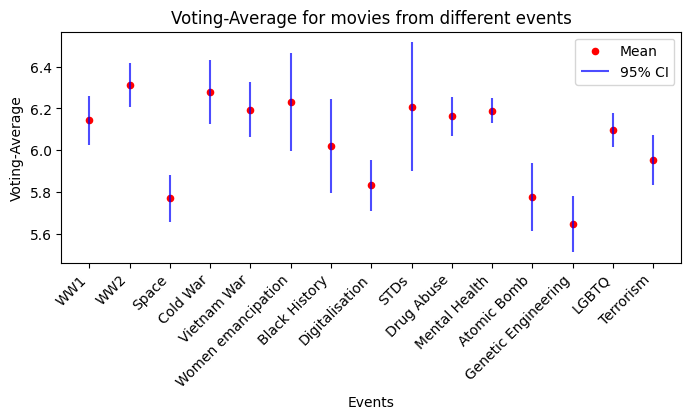

In [48]:
# Represent the different voting averages in a scatterplot

all_averages = []
all_conf_intervals = []

for i, element in enumerate(events):
    element_events = movie_affected_to_event(movies_events_df, element)
    element_ratings = element_events['vote_average'].copy()
    element_ratings_cleaned = element_ratings.dropna()
    
    
    # Computing average and 95% confidence interval
    
    avg = element_ratings_cleaned.mean()
    conf_interval = stats.t.interval(0.95, len(element_ratings_cleaned) - 1, loc = avg, scale = stats.sem(element_ratings_cleaned))
    all_averages.append(avg)
    all_conf_intervals.append(conf_interval)

    
# Extracting lower and upper bounds of confidence intervals

lower_bound, upper_bound = zip(*all_conf_intervals)

# Creating a scatter plot 
fig, ax = plt.subplots(figsize = (8, 3))
plt.scatter(range(len(events)), all_averages, marker = 'o', color = 'red', s = 20, label = 'Mean')
plt.vlines(x = range(len(events)), ymin = lower_bound, ymax = upper_bound, color = 'blue', alpha = 0.7, label = '95% CI')

plt.xlabel('Events')
plt.ylabel('Voting-Average')
plt.title('Voting-Average for movies from different events')
plt.xticks(range(len(events)), events, rotation = 45, ha = 'right')

plt.legend()
plt.show()

> When observing the above plot it is important to remark that the y-axis is only between the rating of 5.7 and 6.2. This shows us that the votings all lie relatively close next to eachother. However, it is also important to note that there do exist significant differences between voting-averages from the events where the confidence intervals do not overlap. This means that we can use the differences in voting-average as a tool to find the most impactful event.

#### 4.5 Number of Rating Votes

> A further way to analyse the impact of a movie is to look at how many people rated the movie (meaning that they watched it and that they probably felt strongly enough about it to fill out a rating). This is why we will evaluate the average number of rating votes for each event. 

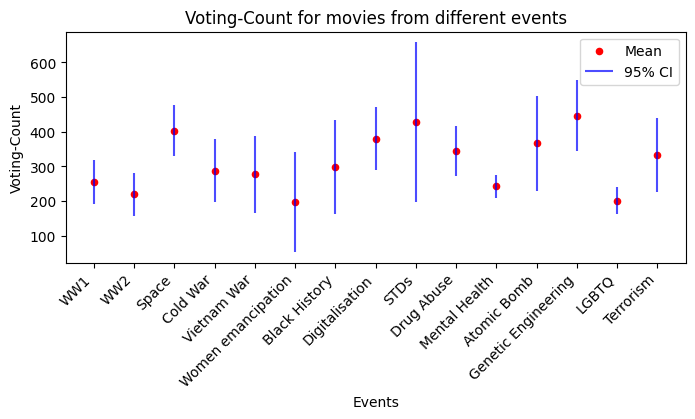

In [49]:
# Represent the different voting count averages in a scatterplot

all_averages = []
all_conf_intervals = []

for i, element in enumerate(events):
    element_events = movie_affected_to_event(movies_events_df, element)
    element_ratings = element_events['vote_count'].copy()
    element_ratings_cleaned = element_ratings.dropna()
    
    
    # Computing average and 95% confidence interval
    
    avg = element_ratings_cleaned.mean()
    conf_interval = stats.t.interval(0.95, len(element_ratings_cleaned) - 1, loc = avg, scale = stats.sem(element_ratings_cleaned))
    all_averages.append(avg)
    all_conf_intervals.append(conf_interval)

    
# Extracting lower and upper bounds of confidence intervals

lower_bound, upper_bound = zip(*all_conf_intervals)

# Creating a scatter plot 
fig, ax = plt.subplots(figsize=(8, 3))
plt.scatter(range(len(events)), all_averages, marker = 'o', color = 'red', s = 20, label = 'Mean')
plt.vlines(x = range(len(events)), ymin = lower_bound, ymax = upper_bound, color = 'blue', alpha = 0.7, label = '95% CI')

plt.xlabel('Events')
plt.ylabel('Voting-Count')
plt.title('Voting-Count for movies from different events')
plt.xticks(range(len(events)), events, rotation = 45, ha = 'right')

plt.legend()
plt.show()

> When observing the plot above, we are able to see that significant differences between voting-count averages for events exist, since the confidence intervals do not overlap. This means that we can use the differences in voting-count average as a tool to find the most impactful event.

#### 4.6 Popularity

> A further way to analyse the impact of a movie is to look at how 'popular' a movie is. For this we use the column 'popularity' that we imported with our imdb database and analyse the average of popularity for the different events. 

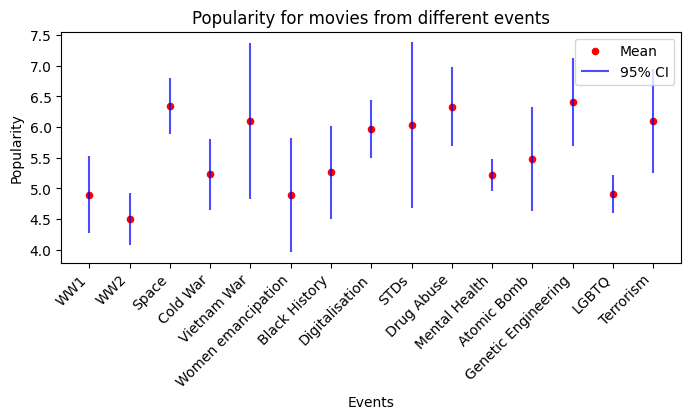

In [50]:
# Represent the different popularity averages in a scatterplot

all_averages = []
all_conf_intervals = []

movies_events_df['popularity'] = pd.to_numeric(movies_events_df['popularity'], errors='coerce')

for i, element in enumerate(events):
    element_events = movie_affected_to_event(movies_events_df, element)
    element_ratings = element_events['popularity'].copy()
    element_ratings_cleaned = element_ratings.dropna()
    
    
    # Computing average and 95% confidence interval
    
    avg = element_ratings_cleaned.mean()
    conf_interval = stats.t.interval(0.95, len(element_ratings_cleaned) - 1, loc = avg, scale = stats.sem(element_ratings_cleaned))
    all_averages.append(avg)
    all_conf_intervals.append(conf_interval)

    
# Extracting lower and upper bounds of confidence intervals

lower_bound, upper_bound = zip(*all_conf_intervals)

# Creating a scatter plot 
fig, ax = plt.subplots(figsize = (8, 3))
plt.scatter(range(len(events)), all_averages, marker = 'o', color = 'red', s = 20, label = 'Mean')
plt.vlines(x=range(len(events)), ymin = lower_bound, ymax = upper_bound, color = 'blue', alpha = 0.7, label = '95% CI')

plt.xlabel('Events')
plt.ylabel('Popularity')
plt.title('Popularity for movies from different events')
plt.xticks(range(len(events)), events, rotation = 45, ha = 'right')

plt.legend()
plt.show()

> When observing the plot above, we are able to see that significant differences between popularity averages for events exist, since the confidance intervals do not overlap. This means that we can use the differences in popularity average as a tool to find the most impactful event.

#### 4.7 Review - Sentiment analysis

>To analyse the feeling that the public conveys through its reviews, we thought of comparing the words they use in their texts to words that are generally associated with positive or negative emotions. To perform this comparison, we used two words' lists from *Patrick O.Perry*, a lead data sceintist at Oscar Health, imported above.

##### 4.7.1 Reviews Preprocessing

> As we have around 90% NaNs in the reviews column, we remove them for further analysis.

In [51]:
movies_events_reviews_df = movies_events_reviews.copy()


# Dropping NaN values respectively in the review_summary and review_detail columns

movies_events_reviews_summary_nona_df = movies_events_reviews_df.dropna(subset = ['review_summary'], axis = 0)
movies_events_reviews_detail_nona_df = movies_events_reviews_df.dropna(subset = ['review_detail'], axis = 0)


# Resetting the index to a default one

movies_events_reviews_summary_nona_df.reset_index(inplace = True)
movies_events_reviews_summary_nona_df = movies_events_reviews_summary_nona_df.drop(['index'], axis = 1)

movies_events_reviews_detail_nona_df.reset_index(inplace = True)
movies_events_reviews_detail_nona_df = movies_events_reviews_detail_nona_df.drop(['index'], axis = 1)

>Before further investigating the reviews' details or summaries, we want to ensure that every movie which has a review summary also has a detailed review. This allows us to guarantee that we did not ignore reviews' summaries by dropping NaN values of detailed reviews and vice-versa.

In [52]:
# Test to see if some movies which have reviews' summaries don't have a detailed review after removing NaNs

for i in range(movies_events_reviews_summary_nona_df.shape[0]):
    if movies_events_reviews_summary_nona_df.iloc[i]['review_detail'] == 'NaN':
        print("There is a movie for which we have a review summary but not a review detail.")
        
print("First test finished.")


# Test to see if some movies which have detailed reviews don't have a reviews' summaries after removing NaNs

for i in range(movies_events_reviews_detail_nona_df.shape[0]):
    if movies_events_reviews_detail_nona_df.iloc[i]['review_summary'] == 'NaN':
        print("There is a movie for which we have a review detail but not a review summary.")
        
print("Second test finished.")

First test finished.
Second test finished.


> Our tests successfully demonstrated that every movie in our processed DataFrame having a review summary has a detailed review and vice versa. Thus, from now on, we will only work on a single dataframe to centralize all our data.
>
>Let's now investigate the outliers' characteristics of reviews.

In [53]:
# Testing for outliers contained in the "review_summary" column

outliers_review_summary = [summary for summary in movies_events_reviews_summary_nona_df['review_summary'] if type(summary) != str]
outliers_review_summary = list(set(outliers_review_summary))
print(outliers_review_summary)


# Testing for outliers contained in the "review_detail" column

outliers_review_summary = [detail for detail in movies_events_reviews_detail_nona_df['review_detail'] if type(detail) != str]
outliers_review_summary = list(set(outliers_review_summary))
print(outliers_review_summary)

[]
[]


>Important observations of the columns 'review_summary' and 'review_detail':
>
>* (NaNs values were already covered above)
>* Apart from Nan's there are no non-string values

##### 4.7.2 Emotions' ratios analysis

>To quantify the emotion transmitted by the public through its reviews, we decided to compute common words' ratios between the reviews' text itself and our positive or negative words' lists. These ratios can give us an idea of the amount of positivity and negativity present in reviews.

In [54]:
movies_events_reviews_emotions_df = movies_events_reviews_summary_nona_df.copy()


# Adding 4 columns to the dataframe containing reviews: 
# 2 columns for positive & negative ratios computed using detailed reviews
# 2 columns for positive & negative ratios computed using reviews' summaries

movies_events_reviews_emotions_df = add_common_words_ratio(movies_events_reviews_emotions_df, 'review_detail', list(positive_words_df['words']), list(negative_words_df['words']))
movies_events_reviews_emotions_df = add_common_words_ratio(movies_events_reviews_emotions_df, 'review_summary', list(positive_words_df['words']), list(negative_words_df['words']))

>To simplify our code, analysis and visualizations, we decided to analyse the emotion transmitted by the reviewer either only in detailed reviews or in reviews summaries. To take a rigorous decision, we thought of performing two Principal Component Analysis (PCA). In fact, this technique is often used to reduce data dimensionality but here we decided to apply it in a different context. Both times, we considered detailed reviews or reviews' summaries as target and corresponding positive and negative emotions' ratios as features. Thus, it allows us to show the amount of variance present in the data explained by the two features for each target and see which column allows us to observe the most differences between positive and negative emotions. 

AttributeError: PathCollection.set() got an unexpected keyword argument 'hue'

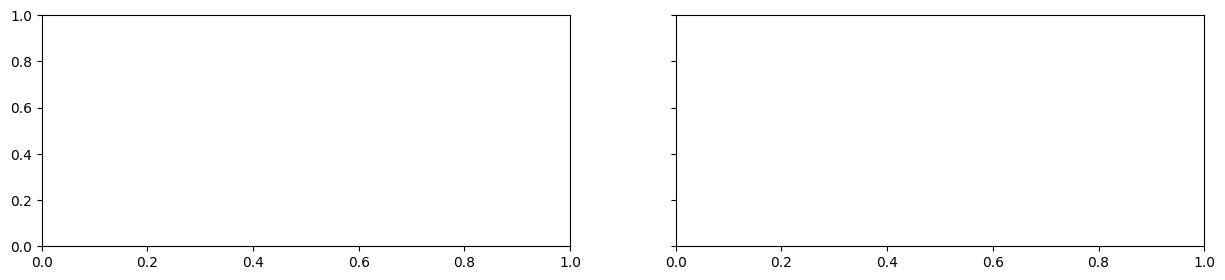

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3), sharex=True, sharey=True)


# Defining the target for both PCAs

pca_target_df = movies_events_reviews_emotions_df[['movie']].sample(20)


# Defining features for both PCAs

detail_pca_data_df = movies_events_reviews_emotions_df[['positive_emotion_ratio_review_detail', 'negative_emotion_ratio_review_detail']]
summary_pca_data_df = movies_events_reviews_emotions_df[['positive_emotion_ratio_review_summary', 'negative_emotion_ratio_review_summary']]


# Plotting the PCAs

pca_plot(detail_pca_data_df, pca_target_df, axs[0])
pca_plot(summary_pca_data_df, pca_target_df, axs[1])

axs[0].set_title("PCA when considering detailed reviews as targets")
axs[1].set_title("PCA when considering reviews' summaries as targets")

plt.show()

>As we can observe on those two 2-dimensional PCA plots, the movies sampled are way more packed together and near the origin when we take the detailed reviews emotion ratios as features than when we are considering the reviews' summaries emotion ratios.
>
>This means that a larger proportion of the emotions' ratios data is explained by reviews' summaries compared to detailed reviews. Indeed, as detailed reviews often contain more words, emotions get diluted in the total amount of words, whereas in the summaries we have less words and the emotional words have more weight.
>
>Thus, from now on, we will only analyse positive and negative emotion ratios computed from reviews' summaries to simplify our analysis and avoid an overload of graphs and conclusions.

In [ ]:
# Plotting regression line in scatter plots of positive and negative emotion ratio per event

fig, axs = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)

scatter_plot_according_events(movies_events_reviews_emotions_df, 'date', 'positive_emotion_ratio_review_summary', axs, events, 'Positive emotion ratio') 
scatter_plot_according_events(movies_events_reviews_emotions_df, 'date', 'negative_emotion_ratio_review_summary', axs, events, 'Negative emotion ratio')

plt.tight_layout()
plt.show()

> We can see that for some of the events the confidence interval are quite large which shows that there is a lot of variance in positive and negative emotions. For the Milestone 3 we could analyze this aspect through the parameters of the linear regression.